# Prediction of Stock Prices

## Overview
#### The idea here is to try and predict the price on 1st September 2024 (Well 3rd Septemebr at thats the monday). The only price we require is the price from 1 year previous to the prediction date. This is because we are trying to simualate a long term (12-months) price target/recommendation.
#### The model will de trained on all data up to 1st September 2023 and then it will be asked to predict the price for the furture!

In this notebook I will evaluate a subset of tech stocks AAPL(Apple), AMZN(Amazon), GOOG(Google) and META (Meta). I will evaluate different Machine Learning Models by only using the historical prices for each stock. Once complete I will then choose the best and create a model for each symbol that can be imported into any standalone program. 

## Data files 
* ./data/price_targets.xlsx - A list of price targets for target date 1st September 2024
* ./data/price_history.xlsx - 5.5 years of historical stock prices
* ./stock_news.xlsx - A list of news articles about each company over the past few years (not very comprehensive but the best I could obtain for free)

## This notebok has the following structure

### 1) Import all relevant 3rd party modules for evaluation models
### 2) Create an Excel file with average daily sentiment scores for each symbol
### 3) Evaluate different models using only price data and find the best
### 4) Create a new model for each symbol and save into the ./models directory
### 5) Check that we can use a saved model without any training or data and use it to make a prediction that matched the pre-saved version


In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime as dt
from datetime import datetime
import nltk
import numpy as np
from sklearn.linear_model import BayesianRidge,LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from IPython.display import display
import pickle

## First obtain the sentiment analysis for each company

In [2]:
# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\trevo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load the Excel file 

In [3]:
file_path = './data/stock_news.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

### Initialize the VADER sentiment analyzer

In [4]:
sid = SentimentIntensityAnalyzer()

### Create a function to apply VADER sentiment analysis to the summary column

In [5]:
def get_sentiment_score(summary):
    sentiment = sid.polarity_scores(summary)
    return sentiment['compound']

### Format the dataframe

In [6]:
df['publishedOn'] = pd.to_datetime(df['publishedOn']).dt.date
# Apply the sentiment analysis function to the 'summary' column
df['sentiment_score'] = df['summary'].apply(get_sentiment_score)

### Group by 'symbol' and 'publishedOn' and calculate the average sentiment score

In [7]:
avg_sentiment = df.groupby(['symbol', 'publishedOn'])['sentiment_score'].mean().reset_index()

### Save the sentiment result to a new Excel file

In [8]:
sentiment_file_path = './data/average_sentiment_by_symbol_date.xlsx'
avg_sentiment.to_excel(sentiment_file_path, index=False)
print(f"Average sentiment scores saved to {sentiment_file_path}")

Average sentiment scores saved to ./data/average_sentiment_by_symbol_date.xlsx


# Now lets try and predict target stock prices


### First set up the parameters used in all model evaluations

In [9]:
# Load the dataset, historical prices can be found on a number of providers websites e.g. yahoo finance
file_path = './data/price_history.xlsx'  # Replace with your file path
df = pd.read_excel(file_path)

# Load the price/analysts targets file
# Analyst target prices for comparison, these targets can be obtained from 
# Yahoo Finance, Google Finance etc. For this experimental model I have
# used targets set on 1st september 2023 for september 20204 i.e. 12 month price targets
price_targets_file_path = './data/price_targets.xlsx'
price_targets_df = pd.read_excel(price_targets_file_path)
analyst_targets = price_targets_df.set_index('symbol')['target_price'].to_dict()

# Convert the close_price_date to datetime format and extract features
df['close_price_date'] = pd.to_datetime(df['close_price_date'])

# Extracting features from the date column
df['day_of_week'] = df['close_price_date'].dt.dayofweek
df['month'] = df['close_price_date'].dt.month
df['year'] = df['close_price_date'].dt.year

# Date to predict: 1st September 2024
predict_date = pd.Timestamp('2024-09-03')

# Extract the previous close price from the last available data
def get_last_available_previous_price(symbol_df):
    return symbol_df[symbol_df['close_price_date'] == symbol_df['close_price_date'].max()]['close_price'].values[0]

# Select features for training
features = ['day_of_week', 'month', 'year', 'previous_close_price']

# Train and predict for each stock symbol
symbols = df['symbol'].unique()

### Evaluate using a Randomized searchCV model to predict prices based only on historic prices

In [10]:
searchCV_results = []

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.1],
    'criterion': ['squared_error', 'absolute_error'],
    'oob_score': [True, False]
}

param_dist_with_max_samples = {
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 1.0]
}

# Set cutoff date for training data
train_cutoff_date = pd.Timestamp('2023-09-01')
df_train = df[df['close_price_date'] < train_cutoff_date]

# Loop through each stock symbol
for symbol in symbols:
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Create 'previous_close_price' feature and drop rows with NaN values
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target variable
    features = ['day_of_week', 'month', 'year', 'previous_close_price']  # Adjust this as needed
    X = df_symbol[features]
    y = df_symbol['close_price']

    # Split the data into training and test sets (no shuffle to preserve time-series order)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Normalize the input features
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    # Initialize RandomForest and RandomizedSearchCV
    rf = RandomForestRegressor(random_state=42)

    rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions={**param_dist, **param_dist_with_max_samples},
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Train the model
    print(f"Training RandomForest model with tuning for {symbol}...")
    rf_random.fit(X_train_norm, y_train)

    # Get the last available previous close price for the stock
    last_close_price = df_symbol['previous_close_price'].iloc[-1]

    # Prepare input data for future prediction (e.g., for 1st September 2024)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })

    # Normalize the input features for prediction
    predict_data_norm = scaler.transform(predict_data)

    # Predict the price for 1st September 2024
    predicted_price = rf_random.best_estimator_.predict(predict_data_norm)[0]

    # Get the actual close price for 1st September 2024, if available in the dataset
    actual_price = df.loc[(df['symbol'] == symbol) & (df['close_price_date'] == predict_date), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    # Calculate percentage differences if actual price is available
    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results for this symbol
    searchCV_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

print(searchCV_results)

Training RandomForest model with tuning for AAPL...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for GOOG...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for META...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for AMZN...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[{'symbol': 'AAPL', 'target_date': '03/09/2024', 'predicted_price': 170.77434999999892, 'analyst_target_price': 198, 'actual_price': 222.77, 'predicted_percent_diff': -23.340508147417108, 'analyst_percent_diff': -11.119091439601386}, {'symbol': 'GOOG', 'target_date': '03/09/2024', 'predicted_price': 131.5871875, 'analyst_target_price': 140, 'actual_price': 158.61, 'predicted_percent_diff': -17.037269087699396, 'analyst_percent_diff': -11.733182018788229}, {'symbol': 'META', 'target_date': '03/09/2024', 'predicted_price': 294.102834797

### Evaluate using a Polynominal Regression model to predict prices based only on historic prices
### No training cut off in this one, its purely for a comparison

In [11]:
# Train and predict for each stock symbol
polynom_results = []

# Polynomial regression for each stock
for symbol in symbols:
    # Filter data for the current symbol
    df_symbol = df[df['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Create polynomial features for prediction
    predict_data_poly = poly.transform(predict_data)
    predict_data_scaled = scaler.transform(predict_data_poly)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

    # Get the actual close price for 1st September 2024, if available in the dataset
    actual_price = df_symbol[df_symbol['close_price_date'] == predict_date]['close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    polynom_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Evaluate using a Polynominal Regression model to predict prices based only on historic prices, but in this case only prices before 1st September 2023

In [12]:
polynom_dateres_results = []
train_cutoff_date = pd.Timestamp('2023-09-01')
df_train = df[df['close_price_date'] < train_cutoff_date]

# Polynomial regression for each stock
for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2024
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    
    # Split the data into training and test sets (training only)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Create polynomial features for prediction
    predict_data_poly = poly.transform(predict_data)
    predict_data_scaled = scaler.transform(predict_data_poly)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

     # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    polynom_dateres_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Evaluate using a XBoost  model to predict prices based only on historic prices

In [13]:
xboost_results = []

# XGBoost regression for each stock
for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2024
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Split the data into training and test sets (training only)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit XGBoost model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Scale prediction data
    predict_data_scaled = scaler.transform(predict_data)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

    # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    # Calculate % difference between predicted and actual price
    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    xboost_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Show a comparison of the models evaluated 

In [14]:
xgboost_df = pd.DataFrame(xboost_results).rename(columns={'predicted_percent_diff': 'xgboost_dateres_percent_diff'})
polynom_dateres_df = pd.DataFrame(polynom_dateres_results).rename(columns={'predicted_percent_diff': 'polynom_dateres_percent_diff'})
polynom_df = pd.DataFrame(polynom_results).rename(columns={'predicted_percent_diff': 'polynom_percent_diff'})
searchCV_df = pd.DataFrame(searchCV_results).rename(columns={'predicted_percent_diff': 'searchCV_percent_diff'})
print(searchCV_df)

merged_df = xgboost_df.merge(polynom_dateres_df[['symbol', 'target_date', 'polynom_dateres_percent_diff']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(polynom_df[['symbol', 'target_date', 'polynom_percent_diff']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(searchCV_df[['symbol', 'target_date', 'searchCV_percent_diff']], on=['symbol', 'target_date'], how='left')

cols = [col for col in merged_df.columns if col != 'xgboost_dateres_percent_diff']  

cols.append('xgboost_dateres_percent_diff')  
merged_df = merged_df[cols]  

# Define a custom formatter for percentage columns
def format_percentage(value):
    return "{:.2f}%".format(value)

formatted_df = merged_df.style.format({
    'analyst_percent_diff': format_percentage,
    'polynom_dateres_percent_diff': format_percentage,
    'polynom_percent_diff': format_percentage,
    'searchCV_percent_diff': format_percentage,
    'xgboost_dateres_percent_diff': format_percentage  # Moved to the end
})

formatted_df.set_caption("Merged Predicted Price Differences")

display(formatted_df.set_caption("Merged Predicted Price Differences"))

  symbol target_date  predicted_price  analyst_target_price  actual_price  \
0   AAPL  03/09/2024       170.774350                   198        222.77   
1   GOOG  03/09/2024       131.587187                   140        158.61   
2   META  03/09/2024       294.102835                   300        511.76   
3   AMZN  03/09/2024       130.970655                   149        176.25   

   searchCV_percent_diff  analyst_percent_diff  
0             -23.340508            -11.119091  
1             -17.037269            -11.733182  
2             -42.531102            -41.378771  
3             -25.690409            -15.460993  


,symbol,target_date,predicted_price,analyst_target_price,actual_price,analyst_percent_diff,polynom_dateres_percent_diff,polynom_percent_diff,searchCV_percent_diff,xgboost_dateres_percent_diff
0,AAPL,03/09/2024,175.931519,198,222.770000,-11.12%,-22.05%,-2.15%,-23.34%,-21.03%
1,GOOG,03/09/2024,137.042099,140,158.610000,-11.73%,-18.55%,-8.22%,-17.04%,-13.60%
2,META,03/09/2024,302.232513,300,511.760000,-41.38%,-77.47%,-5.74%,-42.53%,-40.94%
3,AMZN,03/09/2024,136.225845,149,176.250000,-15.46%,-29.77%,-1.42%,-25.69%,-22.71%


### Plot the differences for each model for each of the 4 stocks in a graph

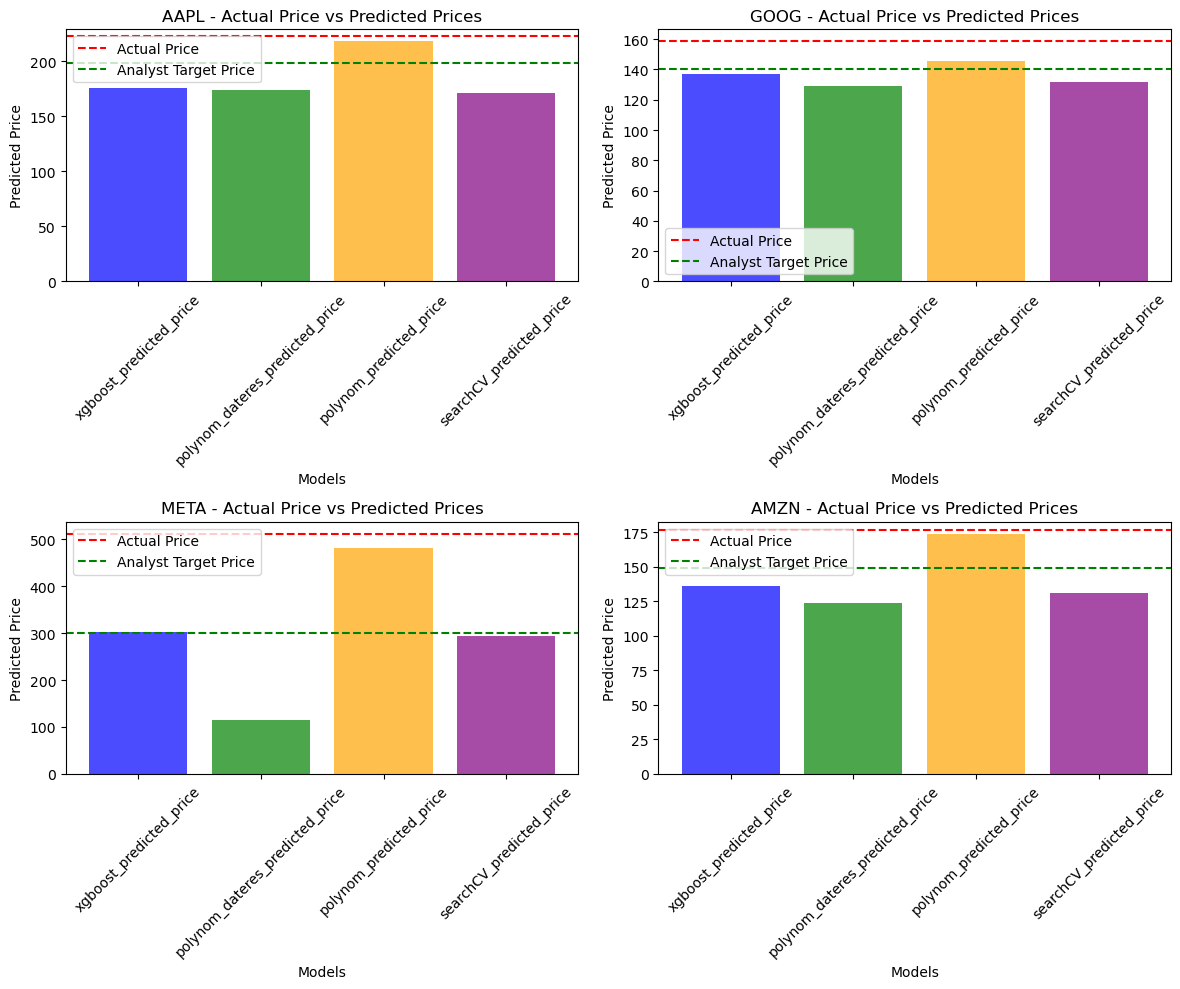

In [15]:
# Example data
xgboost_df = pd.DataFrame(xboost_results).rename(columns={'predicted_price': 'xgboost_predicted_price'})
polynom_dateres_df = pd.DataFrame(polynom_dateres_results).rename(columns={'predicted_price': 'polynom_dateres_predicted_price'})
polynom_df = pd.DataFrame(polynom_results).rename(columns={'predicted_price': 'polynom_predicted_price'})
searchCV_df = pd.DataFrame(searchCV_results).rename(columns={'predicted_price': 'searchCV_predicted_price'})

# Merge the DataFrames
merged_df = xgboost_df.merge(polynom_dateres_df[['symbol', 'target_date', 'polynom_dateres_predicted_price']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(polynom_df[['symbol', 'target_date', 'polynom_predicted_price']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(searchCV_df[['symbol', 'target_date', 'searchCV_predicted_price']], on=['symbol', 'target_date'], how='left')

# Define the model names and colors for the bars
model_names = ['xgboost_predicted_price', 'polynom_dateres_predicted_price', 'polynom_predicted_price', 'searchCV_predicted_price']
colors = ['blue', 'green', 'orange', 'purple']

# Create subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate over the axes

# Iterate through each symbol and plot
for i, symbol in enumerate(merged_df['symbol'].unique()):
    
    symbol_data = merged_df[merged_df['symbol'] == symbol]
    
    predicted_prices = symbol_data[model_names].values.flatten()
    actual_price = symbol_data['actual_price'].values[0]
    analyst_target_price = symbol_data['analyst_target_price'].values[0]
    axes[i].bar(model_names, predicted_prices, color=colors, alpha=0.7)
    
    axes[i].axhline(y=actual_price, color='red', linestyle='--', label='Actual Price')
    
    axes[i].axhline(y=analyst_target_price, color='green', linestyle='--', label='Analyst Target Price')
    
    axes[i].set_title(f'{symbol} - Actual Price vs Predicted Prices')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Predicted Price')
    
    axes[i].tick_params(axis='x', rotation=45)
    
    axes[i].legend(['Actual Price', 'Analyst Target Price'])


plt.tight_layout()
plt.show()

# THE SECTION BELOW IS MY ACTUAL CODE, IT CREATES MODELS IN THE ./models DIRECTORY

### Taking into account the date resttriction on balance the model nearest the analyst price and price target is a XGBoost. 
### I will use this going forward below.
### Now I run the XGBoost but this time I add in news sentiment scores, I will use the daily average, 3 month average and 1 month average.
### The code below is completely standalone and the rest of the notebook does not need to be run to use it 

,symbol,target_date,predicted_price,analyst_target_price,actual_price,predicted_percent_diff,analyst_percent_diff
0,AAPL,03/09/2024,172.338699,198,222.770000,-22.64%,-11.12%
1,AMZN,03/09/2024,135.483582,149,176.250000,-23.13%,-15.46%
2,GOOG,03/09/2024,135.628799,140,158.610000,-14.49%,-11.73%
3,META,03/09/2024,296.556763,300,511.760000,-42.05%,-41.38%


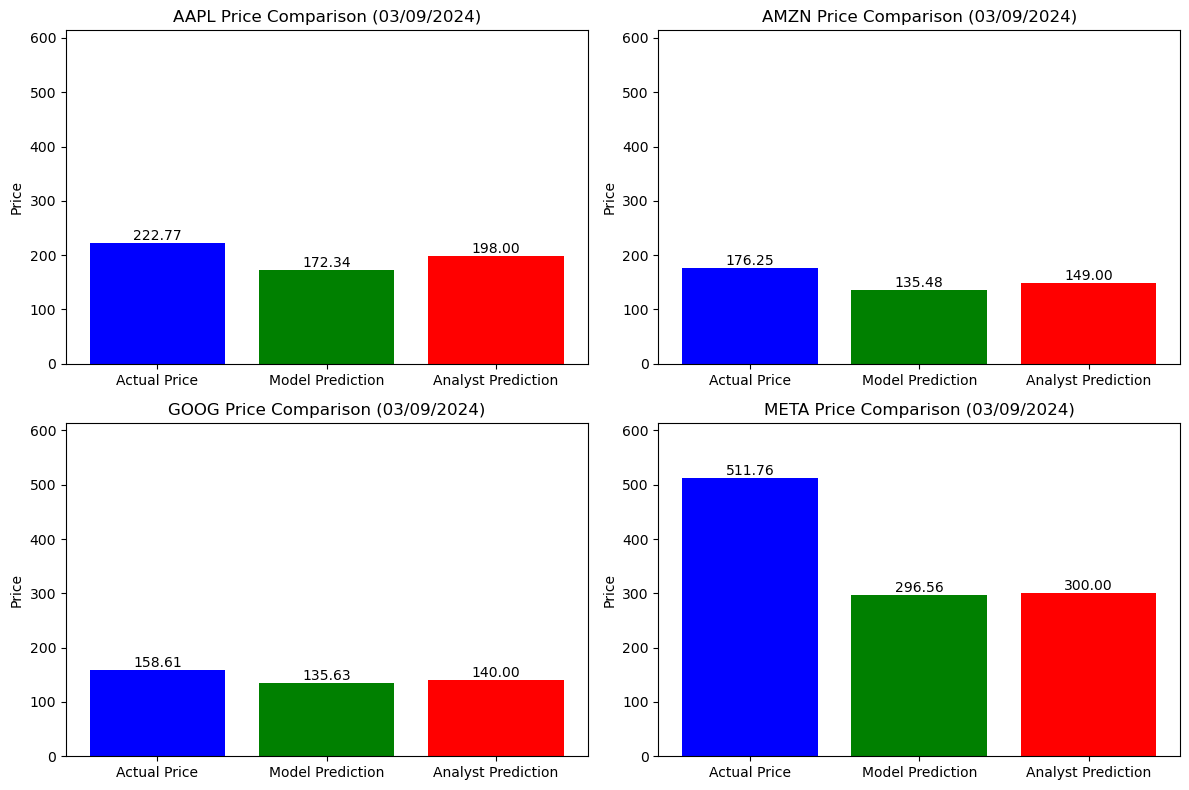

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import os
import matplotlib.pyplot as plt

# Define the format_percentage function
def format_percentage(value):
    return "{:.2f}%".format(value) if value is not None else "N/A"

sentiment_file_path = './data/average_sentiment_by_symbol_date.xlsx'

# Load the sentiment data
sentiment_df = pd.read_excel(sentiment_file_path)

price_history_file_path = './data/price_history.xlsx'

# Load the price history data
df = pd.read_excel(price_history_file_path)

# Convert the close_price_date to datetime format and extract features
df['close_price_date'] = pd.to_datetime(df['close_price_date'])
sentiment_df['publishedOn'] = pd.to_datetime(sentiment_df['publishedOn'])

# Rename columns for consistency
sentiment_df.rename(columns={'publishedOn': 'close_price_date', 'sentiment_score': 'average_sentiment'}, inplace=True)

# Merge the sentiment data with the price history data based on symbol and date
df_merged = pd.merge(df, sentiment_df[['symbol', 'close_price_date', 'average_sentiment']], 
                     on=['symbol', 'close_price_date'], how='left')

# Fill missing sentiment values with 0
df_merged['average_sentiment'] = df_merged['average_sentiment'].fillna(0)

# Calculate the rolling sentiment scores
df_merged = df_merged.sort_values(by=['symbol', 'close_price_date'])  # Sort to ensure proper rolling calculation
df_merged['sentiment_3m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=90, min_periods=1).mean()).reset_index(level=0, drop=True)
df_merged['sentiment_1m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=30, min_periods=1).mean()).reset_index(level=0, drop=True)

# Extract day_of_week, month, and year from the date column
df_merged['day_of_week'] = df_merged['close_price_date'].dt.dayofweek
df_merged['month'] = df_merged['close_price_date'].dt.month
df_merged['year'] = df_merged['close_price_date'].dt.year

# Set the training data cutoff date
train_cutoff_date = pd.Timestamp('2023-09-01')
df_train = df_merged[df_merged['close_price_date'] < train_cutoff_date]

# XGBoost regression for each stock symbol with sentiment
xgboost_results = []
symbols = df_train['symbol'].unique()

for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2023
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target, including 3-month and 1-month sentiment averages
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price', 'average_sentiment', 'sentiment_3m_avg', 'sentiment_1m_avg']]
    y = df_symbol['close_price']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000, learning_rate=0.8)
    xgboost_model.fit(X_train_scaled, y_train)

    # Save the model and scaler
    with open(f'./models/{symbol}_xgboost_model.pkl', 'wb') as file:
        pickle.dump(xgboost_model, file)

    with open(f'./models/{symbol}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = df_symbol['previous_close_price'].iloc[-1]  # Last available close price
    last_sentiment = df_symbol['average_sentiment'].iloc[-1]  # Last available sentiment score
    last_sentiment_3m = df_symbol['sentiment_3m_avg'].iloc[-1]  # Last 3-month sentiment average
    last_sentiment_1m = df_symbol['sentiment_1m_avg'].iloc[-1]  # Last 1-month sentiment average
    
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price],
        'average_sentiment': [last_sentiment],
        'sentiment_3m_avg': [last_sentiment_3m],
        'sentiment_1m_avg': [last_sentiment_1m]
    })
    
    # Normalize the input features for prediction
    predict_data_scaled = scaler.transform(predict_data)

    # Predict the price
    predicted_price = xgboost_model.predict(predict_data_scaled)[0]

    # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    xgboost_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

# Apply the formatting to the percentage difference columns
formatted_df = pd.DataFrame(xgboost_results).style.format({
    'analyst_percent_diff': format_percentage,
    'predicted_percent_diff': format_percentage
})

# Display the formatted DataFrame
display(formatted_df.set_caption("Sentiment Predicted Price Differences"))

# 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Symbols and results
symbols = [result['symbol'] for result in xgboost_results]
actual_prices = [result['actual_price'] for result in xgboost_results]
predicted_prices = [result['predicted_price'] for result in xgboost_results]
analyst_prices = [result['analyst_target_price'] for result in xgboost_results]

# Iterate over the symbols and plot each in a 2x2 grid
for idx, symbol in enumerate(symbols):
    ax = axes[idx // 2, idx % 2]
    
    # Data to be plotted
    categories = ['Actual Price', 'Model Prediction', 'Analyst Prediction']
    values = [actual_prices[idx], predicted_prices[idx], analyst_prices[idx]]
    
    # Bar plot for actual, predicted, and analyst prices
    bars = ax.bar(categories, values, color=['blue', 'green', 'red'])
    
    # Set title, labels, and limits
    ax.set_title(f'{symbol} Price Comparison (03/09/2024)')
    ax.set_ylabel('Price')
    ax.set_ylim([0, max(actual_prices + predicted_prices + analyst_prices) * 1.2])  # Set limit to accommodate highest bar
    
    # Add values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

### Lets check by doing a model import and re-testing
### This means we can obtain predictions simply by providing the X data to predict
### This is also a standalone program that loads model files and makes a prediction

In [17]:
import pickle
import pandas as pd

def load_and_predict(symbol, predict_data):
    # Load the trained XGBoost model
    model_file = './models/' + symbol + '_xgboost_model.pkl'
    with open(model_file, 'rb') as model_file:
        loaded_model = pickle.load(model_file)

    # Load the scaler
    scaler_file = './models/' + symbol + '_scaler.pkl'
    with open(scaler_file, 'rb') as scaler_file:
        loaded_scaler = pickle.load(scaler_file)
    
    # Scale the input prediction data
    predict_data_scaled = loaded_scaler.transform(predict_data)

    # Predict the price using the XGBoost model
    predicted_price = loaded_model.predict(predict_data_scaled)[0]
    print(f"{symbol} Predicted Price: {predicted_price}")

# Example prediction for AAPL
predict_data = pd.DataFrame({
    'day_of_week': [1],         # Example for Tuesday (0=Monday, 6=Sunday)
    'month': [9],               # September
    'year': [2024],             # Year 2024
    'previous_close_price': [187.46],  # Close price for 1 year previous
    'average_sentiment': [0.0],        # Average sentiment for the day
    'sentiment_3m_avg': [0.020873],    # 3-month sentiment average
    'sentiment_1m_avg': [-0.0165]      # 1-month sentiment average
})

load_and_predict('AAPL', predict_data)

# Example prediction for GOOG
predict_data = pd.DataFrame({
    'day_of_week': [1],         # Example for Tuesday (0=Monday, 6=Sunday)
    'month': [9],               # September
    'year': [2024],             # Year 2024
    'previous_close_price': [136.93],  # Close price for 1 year previous
    'average_sentiment': [0.0],        # Average sentiment for the day
    'sentiment_3m_avg': [0.069762],    # 3-month sentiment average
    'sentiment_1m_avg': [0.086998]     # 1-month sentiment average
})

load_and_predict('GOOG', predict_data)


# Example of prediction for GOOG but change the sentiments
predict_data = pd.DataFrame({
    'day_of_week': [1],         # Example for Tuesday (0=Monday, 6=Sunday)
    'month': [9],               # September
    'year': [2024],             # Year 2024
    'previous_close_price': [136.93],  # Close price for 1 year previous
    'average_sentiment': [0],        # Average sentiment for the day
    'sentiment_3m_avg': [-1000],    # 3-month sentiment average
    'sentiment_1m_avg': [-34]     # 1-month sentiment average
})

load_and_predict('GOOG', predict_data)


AAPL Predicted Price: 172.3386993408203
GOOG Predicted Price: 135.62879943847656
GOOG Predicted Price: 137.2505340576172


In [18]:
## Now lets see if by training the model with data up to 6 months before the target date (i.e. 1st Mark 2024) The target is improved

,symbol,target_date,predicted_price,analyst_target_price,actual_price,predicted_percent_diff,analyst_percent_diff
0,AAPL,03/09/2024,175.765564,198,222.770000,-21.10%,-11.12%
1,AMZN,03/09/2024,168.114914,149,176.250000,-4.62%,-15.46%
2,GOOG,03/09/2024,138.112778,140,158.610000,-12.92%,-11.73%
3,META,03/09/2024,369.800049,300,511.760000,-27.74%,-41.38%


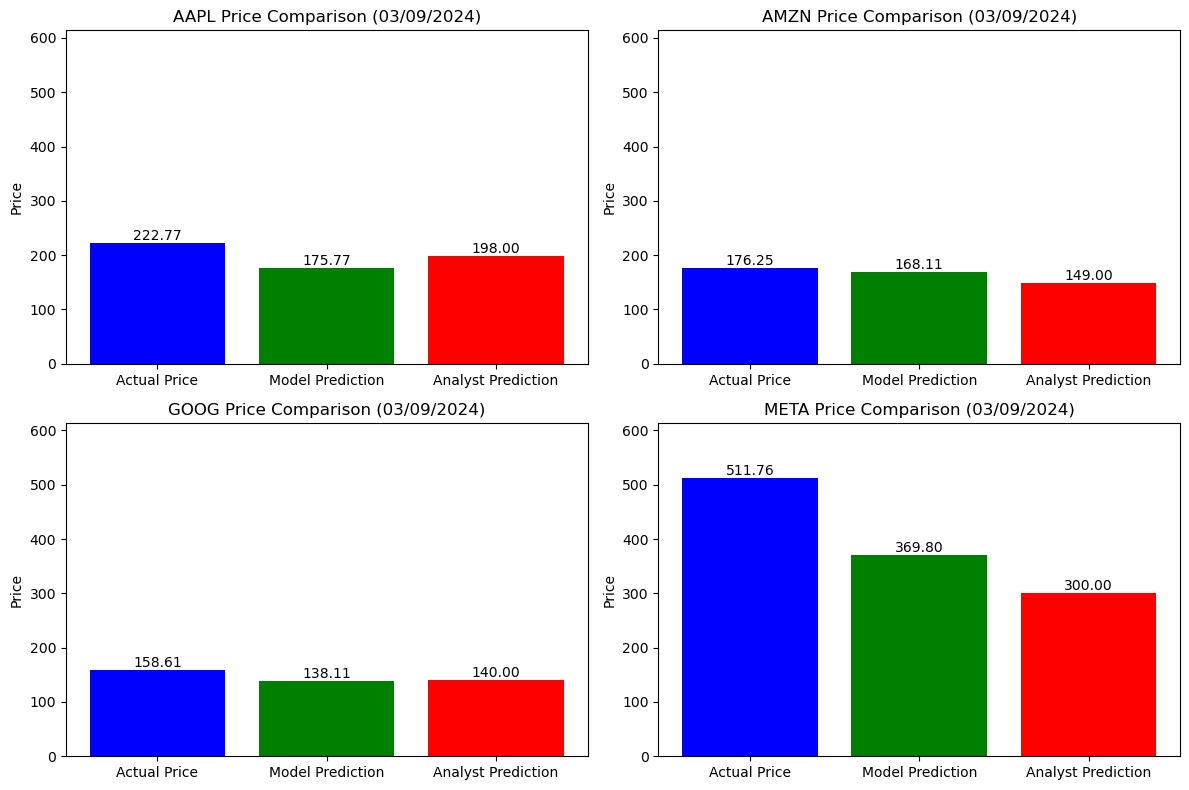

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import pickle
import os
import matplotlib.pyplot as plt

# Define the format_percentage function
def format_percentage(value):
    return "{:.2f}%".format(value) if value is not None else "N/A"

sentiment_file_path = './data/average_sentiment_by_symbol_date.xlsx'

# Load the sentiment data
sentiment_df = pd.read_excel(sentiment_file_path)

price_history_file_path = './data/price_history.xlsx'

# Load the price history data
df = pd.read_excel(price_history_file_path)

# Convert the close_price_date to datetime format and extract features
df['close_price_date'] = pd.to_datetime(df['close_price_date'])
sentiment_df['publishedOn'] = pd.to_datetime(sentiment_df['publishedOn'])

# Rename columns for consistency
sentiment_df.rename(columns={'publishedOn': 'close_price_date', 'sentiment_score': 'average_sentiment'}, inplace=True)

# Merge the sentiment data with the price history data based on symbol and date
df_merged = pd.merge(df, sentiment_df[['symbol', 'close_price_date', 'average_sentiment']], 
                     on=['symbol', 'close_price_date'], how='left')

# Fill missing sentiment values with 0
df_merged['average_sentiment'] = df_merged['average_sentiment'].fillna(0)

# Calculate the rolling sentiment scores
df_merged = df_merged.sort_values(by=['symbol', 'close_price_date'])  # Sort to ensure proper rolling calculation
df_merged['sentiment_3m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=90, min_periods=1).mean()).reset_index(level=0, drop=True)
df_merged['sentiment_1m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=30, min_periods=1).mean()).reset_index(level=0, drop=True)

# Extract day_of_week, month, and year from the date column
df_merged['day_of_week'] = df_merged['close_price_date'].dt.dayofweek
df_merged['month'] = df_merged['close_price_date'].dt.month
df_merged['year'] = df_merged['close_price_date'].dt.year

# Set the training data cutoff date
train_cutoff_date = pd.Timestamp('2024-03-01')
df_train = df_merged[df_merged['close_price_date'] < train_cutoff_date]

# XGBoost regression for each stock symbol with sentiment
xgboost_results = []
symbols = df_train['symbol'].unique()

for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2023
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target, including 3-month and 1-month sentiment averages
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price', 'average_sentiment', 'sentiment_3m_avg', 'sentiment_1m_avg']]
    y = df_symbol['close_price']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000, learning_rate=0.8)
    xgboost_model.fit(X_train_scaled, y_train)

    # Save the model and scaler
    with open(f'./models/{symbol}_xgboost_model.pkl', 'wb') as file:
        pickle.dump(xgboost_model, file)

    with open(f'./models/{symbol}_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = df_symbol['previous_close_price'].iloc[-1]  # Last available close price
    last_sentiment = df_symbol['average_sentiment'].iloc[-1]  # Last available sentiment score
    last_sentiment_3m = df_symbol['sentiment_3m_avg'].iloc[-1]  # Last 3-month sentiment average
    last_sentiment_1m = df_symbol['sentiment_1m_avg'].iloc[-1]  # Last 1-month sentiment average
    
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price],
        'average_sentiment': [last_sentiment],
        'sentiment_3m_avg': [last_sentiment_3m],
        'sentiment_1m_avg': [last_sentiment_1m]
    })
    
    # Normalize the input features for prediction
    predict_data_scaled = scaler.transform(predict_data)

    # Predict the price
    predicted_price = xgboost_model.predict(predict_data_scaled)[0]

    # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    xgboost_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

# Apply the formatting to the percentage difference columns
formatted_df = pd.DataFrame(xgboost_results).style.format({
    'analyst_percent_diff': format_percentage,
    'predicted_percent_diff': format_percentage
})

# Display the formatted DataFrame
display(formatted_df.set_caption("Sentiment Predicted Price Differences"))

# 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Symbols and results
symbols = [result['symbol'] for result in xgboost_results]
actual_prices = [result['actual_price'] for result in xgboost_results]
predicted_prices = [result['predicted_price'] for result in xgboost_results]
analyst_prices = [result['analyst_target_price'] for result in xgboost_results]

# Iterate over the symbols and plot each in a 2x2 grid
for idx, symbol in enumerate(symbols):
    ax = axes[idx // 2, idx % 2]
    
    # Data to be plotted
    categories = ['Actual Price', 'Model Prediction', 'Analyst Prediction']
    values = [actual_prices[idx], predicted_prices[idx], analyst_prices[idx]]
    
    # Bar plot for actual, predicted, and analyst prices
    bars = ax.bar(categories, values, color=['blue', 'green', 'red'])
    
    # Set title, labels, and limits
    ax.set_title(f'{symbol} Price Comparison (03/09/2024)')
    ax.set_ylabel('Price')
    ax.set_ylim([0, max(actual_prices + predicted_prices + analyst_prices) * 1.2])  # Set limit to accommodate highest bar
    
    # Add values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

## This shows that the current and previous days price are more influencial than any other factor such as sentiment. Also the close we get to the date the more close to the prediction. I beleive this is a useful tool but, maybe I need to look also at the analyst estimates/recommendations and create a model based on that as the Y value on an annual basis.....next project!